In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
iris = load_iris()
x = iris.data
y = iris.target
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

<AxesSubplot:>

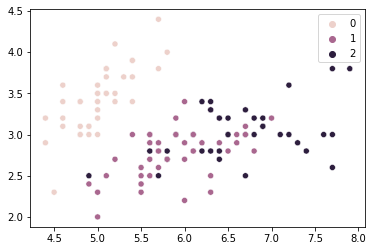

In [4]:
sns.scatterplot(x=x_train[:,0], y=x_train[:,1], hue=y_train)

In [5]:
class irisData(Dataset):
    def __init__(self, x_train, y_train):
        super().__init__()
        self.x = torch.from_numpy(x_train)
        self.y = torch.from_numpy(y_train)
        self.y = self.y.type(torch.LongTensor)
        self.len = self.x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len

In [6]:
iris_data = irisData(x_train,y_train)
training_set = DataLoader(iris_data, batch_size=32)
iris_data.x.shape

torch.Size([120, 4])

In [7]:
class MultiClassModel(nn.Module):
    def __init__(self, num_features, num_classes, hidden_features):
        super().__init__()
        self.linear1 = nn.Linear(num_features,hidden_features)
        self.linear2 = nn.Linear(hidden_features, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1) # dimension to work on rows
    
    def forward(self,x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [8]:
num_features = iris.data.shape[1]
num_classes = len(iris_data.y.unique())
hidden_features = 64 # num of neurons

model = MultiClassModel(num_features,num_classes,hidden_features)

lr = 0.1
epochs = 100
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

losses=[]

for epoch in range(epochs):
    for x,y in training_set:
        optimizer.zero_grad() # initialize grads to 0

        yhat = model(x) # forward pass
        loss = loss_func(yhat,y) # calc loss
        loss.backward() # Calc Gradient
        optimizer.step() # update params

    losses.append(float(loss.data.detach().numpy()))

In [9]:
from torchsummary import summary
summary(model, input_size=x.shape, device='cpu', batch_size=32)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [32, 24, 64]             320
            Linear-2                [32, 24, 3]             195
        LogSoftmax-3                [32, 24, 3]               0
Total params: 515
Trainable params: 515
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.41
Params size (MB): 0.00
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


0.9666666666666667

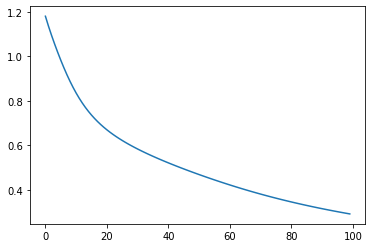

In [10]:
sns.lineplot(x= range(len(losses)), y = losses)
# test the model
X_test_torch = torch.from_numpy(x_test)
with torch.no_grad():
    y_test_hat_softmax = model(X_test_torch)
    y_test_hat = torch.max(y_test_hat_softmax.data, 1)

# Accuracy
accuracy_score(y_test, y_test_hat.indices)

In [11]:

from collections import Counter
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {most_common_cnt / len(y_test) * 100} %")

Naive Classifier: 43.333333333333336 %
